In [99]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from joblib import parallel_backend

In [70]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amrodriguez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amrodriguez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/amrodriguez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/amrodriguez/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes):
    # Calcular la matriz de confusión
    cm = (confusion_matrix(y_true, y_pred)).astype('int')
    
    # Normalizar la matriz de confusión
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Configurar el tamaño de la figura
    plt.figure(figsize=(20, 16))
    
    # Crear el heatmap
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    
    # Configurar las etiquetas y el título
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title('Matriz de Confusión Normalizada para Clasificación de ODS')
    
    # Ajustar el diseño y mostrar
    plt.tight_layout()
    plt.show()

# Lista de los 17 ODS (puedes ajustar los nombres según sea necesario)
ods_classes = [
    "1. Fin de la pobreza",
    "2. Hambre cero",
    "3. Salud y bienestar",
    "4. Educación de calidad",
    "5. Igualdad de género",
    "6. Agua limpia y saneamiento",
    "7. Energía asequible y no contaminante",
    "8. Trabajo decente y crecimiento económico",
    "9. Industria, innovación e infraestructura",
    "10. Reducción de las desigualdades",
    "11. Ciudades y comunidades sostenibles",
    "12. Producción y consumo responsables",
    "13. Acción por el clima",
    "14. Vida submarina",
    "15. Vida de ecosistemas terrestres",
    "16. Paz, justicia e instituciones sólidas",
    "17. Alianzas para lograr los objetivos"
]



In [71]:
textos = pd.read_excel('Train_textosODS.xlsx')

In [72]:
np.sort(textos.ODS.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [82]:
X = textos['textos']
y = textos['ODS']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


([<matplotlib.patches.Wedge at 0x17680b370>,
 [Text(1.0327748990136385, 0.37865024490599364, '16'),
  Text(0.5463797464883983, 0.9547089465524421, '5'),
  Text(-0.17729020282948108, 1.0856188023338034, '4'),
  Text(-0.7784499487137783, 0.7771844551633262, '3'),
  Text(-1.069008760908953, 0.2592687198639771, '7'),
  Text(-1.0674069954880598, -0.265786203522969, '6'),
  Text(-0.8639453017822887, -0.6808806911113798, '11'),
  Text(-0.5672145893823294, -0.9424795008868021, '1'),
  Text(-0.24707780139054294, -1.071892046831217, '13'),
  Text(0.07644496041986668, -1.0973404977610208, '8'),
  Text(0.3643327645742964, -1.0379121526688329, '14'),
  Text(0.6031995911623519, -0.9198642580411371, '2'),
  Text(0.8005662005533162, -0.7543830317097725, '10'),
  Text(0.9493300267825107, -0.5556730155848112, '9'),
  Text(1.0473174208729932, -0.3363424147144421, '15'),
  Text(1.0943182673589897, -0.1116580929642762, '12')],
 [Text(0.5633317630983482, 0.20653649722145104, '11.2%'),
  Text(0.2980253162663

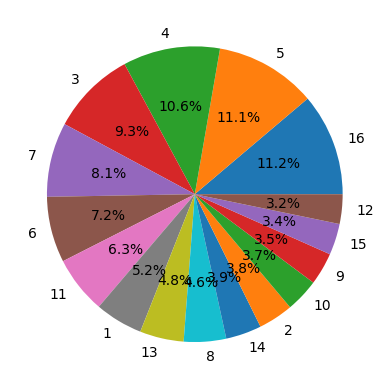

In [84]:

#Contar y normalizar
dfsizes = y_train.value_counts()/y_train.shape[0]
#Crear figura
fig, ax = plt.subplots()
#Pintar
ax.pie(list(dfsizes),labels=list(dfsizes.index) ,autopct='%1.1f%%')

In [85]:
def preprocess_text(text):
    # Tokenización
    tokens = word_tokenize(text.lower())
    # Eliminar stopwords y lematizar
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('spanish'))
    return ' '.join([lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stop_words])

In [87]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=preprocess_text, max_features=5000)),
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

In [88]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000,
                                 preprocessor=<function preprocess_text at 0x31abed310>)),
                ('svd', TruncatedSVD(n_components=100)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [90]:
y_pred = pipeline.predict(X_test)

In [92]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.83      0.73      0.78       101
           2       0.71      0.76      0.73        74
           3       0.79      0.88      0.83       179
           4       0.91      0.95      0.93       205
           5       0.88      0.93      0.90       214
           6       0.89      0.89      0.89       139
           7       0.80      0.87      0.84       158
           8       0.64      0.49      0.56        89
           9       0.64      0.68      0.66        69
          10       0.77      0.66      0.71        70
          11       0.70      0.76      0.73       122
          12       0.83      0.71      0.77        62
          13       0.76      0.75      0.76        93
          14       0.89      0.72      0.79        75
          15       0.96      0.80      0.88        66
          16       0.90      0.92      0.91       216

    accuracy                           0.82      1932
   macro avg       0.81   

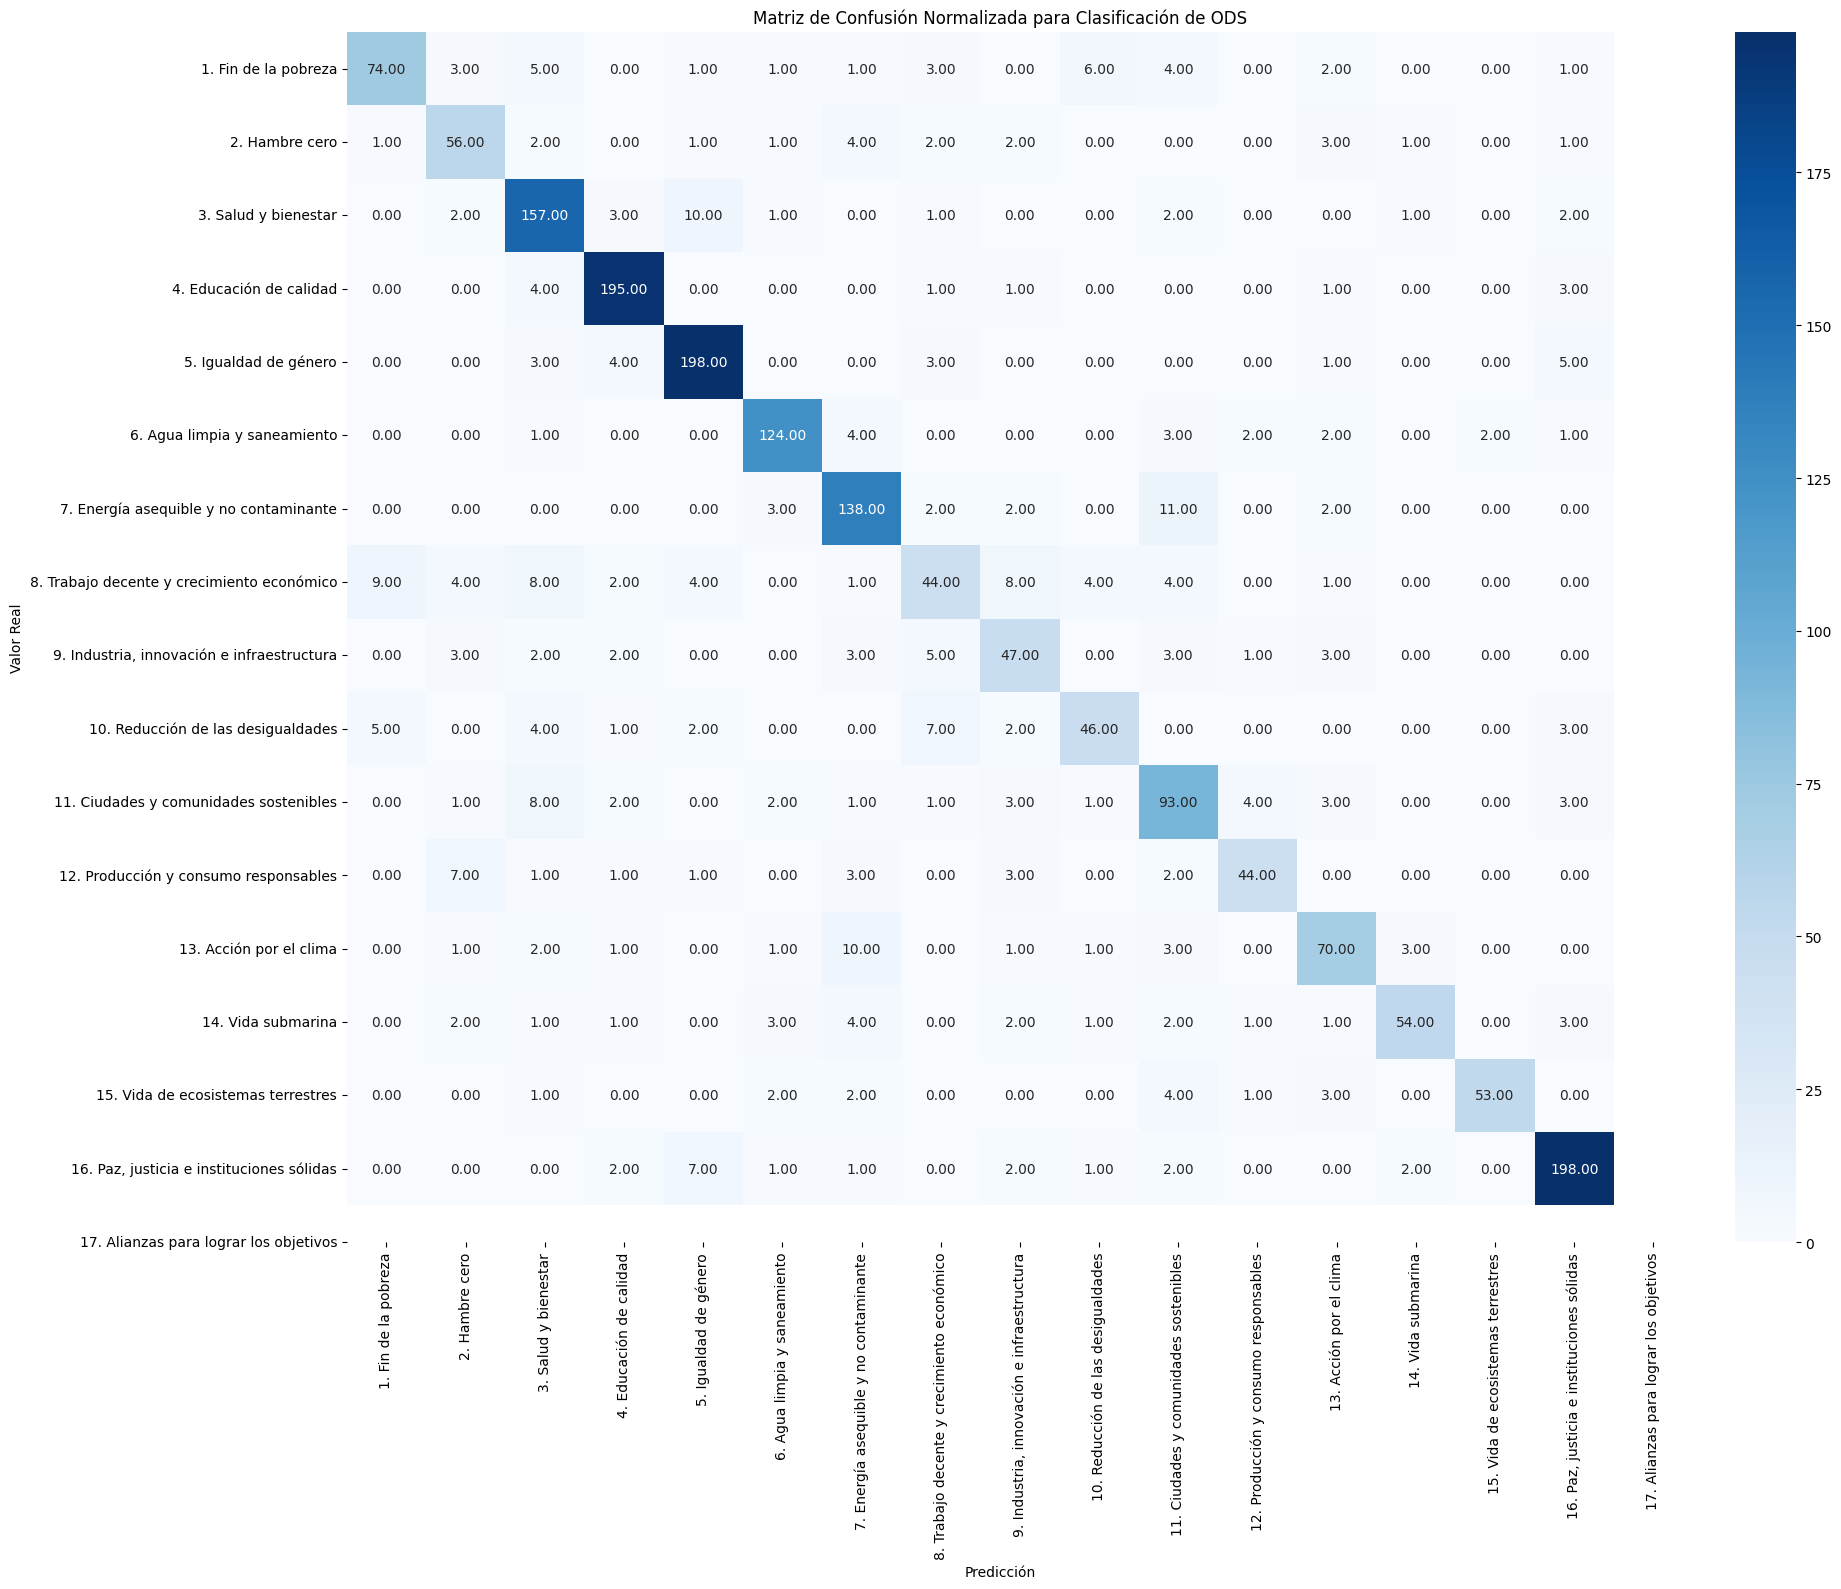

In [93]:
plot_confusion_matrix(y_test, y_pred, ods_classes)

In [95]:
pipeline_2 = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=preprocess_text)),
    ('svd', TruncatedSVD()),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

In [96]:
param_grid = {'tfidf__max_features': [1000, 5000, 10000],
                'svd__n_components': [50, 100, 200],
                'clf__n_estimators': [50, 100, 200]}

In [105]:

scorer = make_scorer(f1_score, average='weighted')
search = GridSearchCV(pipeline_2, param_grid, scoring=scorer, refit='f1', n_jobs=1, cv=5)

In [106]:

search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function preprocess_text at 0x31abed310>)),
                                       ('svd', TruncatedSVD()),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=1,
             param_grid={'clf__n_estimators': [50, 100, 200],
                         'svd__n_components': [50, 100, 200],
                         'tfidf__max_features': [1000, 5000, 10000]},
             refit='f1',
             scoring=make_scorer(f1_score, response_method='predict', average=weighted))

In [107]:
y_pred = search.best_estimator_.predict(X_test)

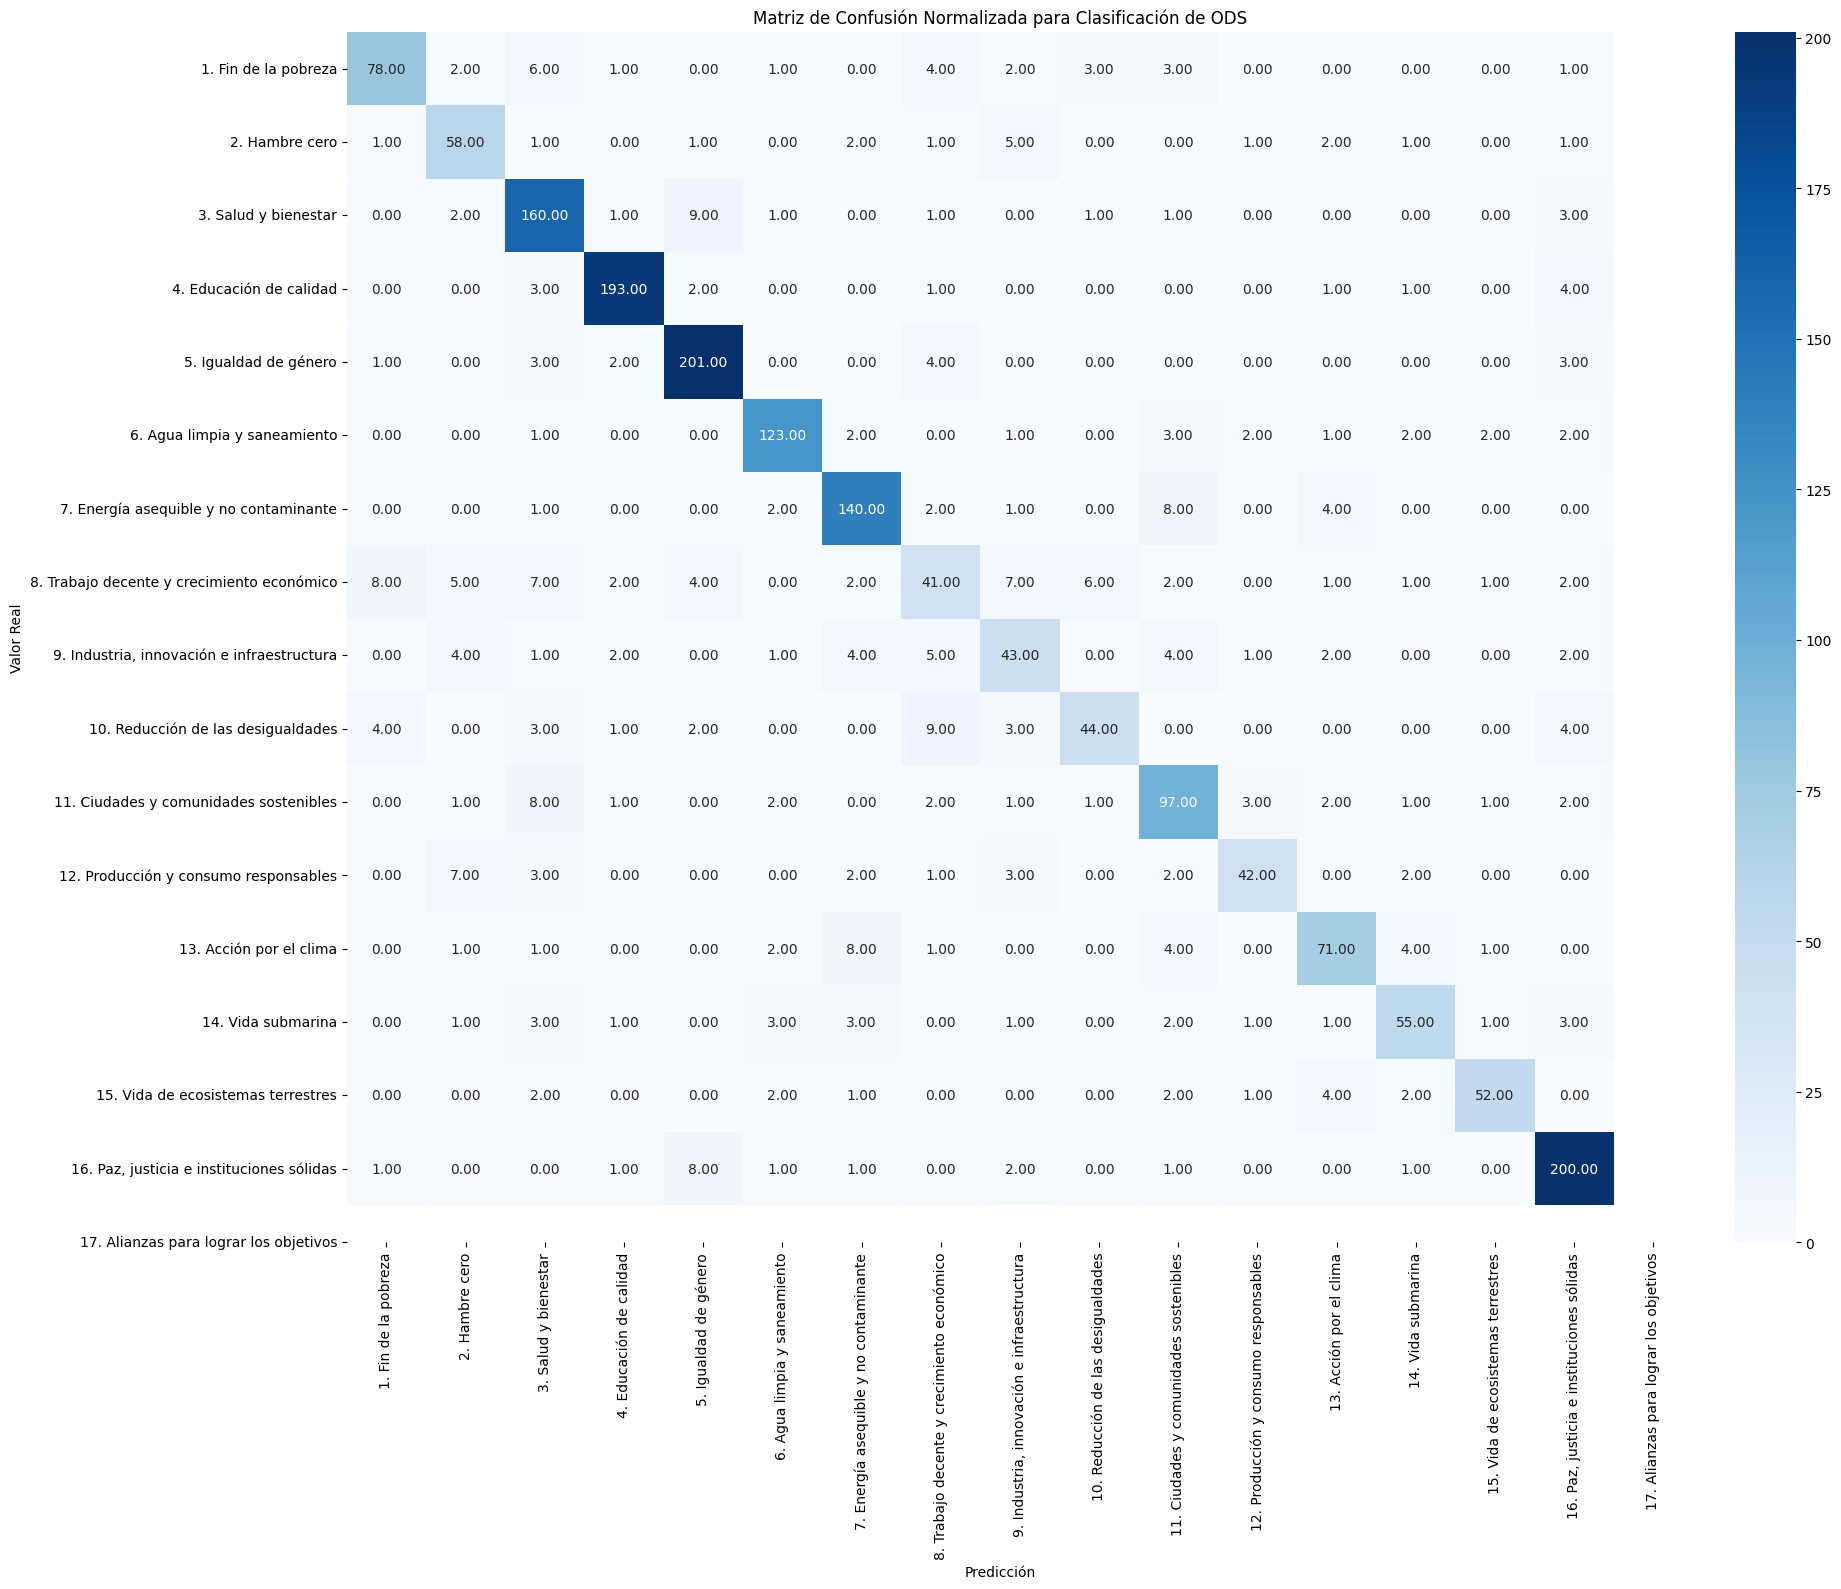

In [108]:

plot_confusion_matrix(y_test, y_pred, ods_classes)

In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.77      0.80       101
           2       0.72      0.78      0.75        74
           3       0.79      0.89      0.84       179
           4       0.94      0.94      0.94       205
           5       0.89      0.94      0.91       214
           6       0.89      0.88      0.89       139
           7       0.85      0.89      0.87       158
           8       0.57      0.46      0.51        89
           9       0.62      0.62      0.62        69
          10       0.80      0.63      0.70        70
          11       0.75      0.80      0.77       122
          12       0.82      0.68      0.74        62
          13       0.80      0.76      0.78        93
          14       0.79      0.73      0.76        75
          15       0.90      0.79      0.84        66
          16       0.88      0.93      0.90       216

    accuracy                           0.83      1932
   macro avg       0.80   